# KI-Werkbank
# Augmentieren bei Neuronale Netze mit Keras

## Worum geht es hier?
In diesem kleinen Blog möchte ich zeigen, warum man Bilder augmentieren sollte, und wie man das in Keras macht.

## Warum Augmentieren und was ist das eigentlich?
Neuronale Netze brauchen für ihr Training sehr viele Samples. Hätten man unendlich viele Samples, könnten man sich in die Beste aller Lösungen hineindrehen und alle wären glücklich. Wir haben aber leider nicht unendlich viele Daten, wir haben eigentlich immer eher zu wenige als zu viele. Was nun?

Der erste extrem simple Trick mit dieser Tatsache umzugehen, ist sicherlich die Daten über so viele Trainingsepochen wiederzuverwenden, bis sie komplett ausgereizt sind. Das entspricht quasi dem Entsaften einer Orange, die man ja auch solange auf den Entsafter - Kopf drückt, bis das ganz Fruchtfleisch seinen Saft hergegeben hat. Hätte man unendlich viele Orangen, bräuchte man das auch nicht, sondern könnte auf jede Hälfte nur einmal kurz draufdrücken.

Man erkennt die Grenze dieses Verfahrens am Overfitting. Der Hypothesenraum schnürt sich dabei immer enger um die Testdaten und wird zunehmend intoleranter gegen Daten, die nicht in der Testmenge sind. Somit ist das Overfitting der Feind, an dem wir uns abkämpfen müssen, wenn wir nicht auf die Epochen verzichten wollen. 

Für Bilder gibt es ein sehr schönes Mittel, um den „death by overfitting“ ein wenig hinauszuschieben: Man verändert die Bilder permanent ein wenig, indem man sie hin und her dreht, spiegelt, verzerrt oder die Farben abändert. Dabei dreht man die maximale Veränderung solange auf, solange man die eigentliche Information auf dem Bild noch gut erkennen kann. Das neuronale Netz sieht dann ein Bild, das seinem Original zwar ähnelt aber eben nicht ganz gleich ist. Dieses Verfahren nennt man __Augmentieren__.


## Wie macht Keras das?
Da man mit diesem Konzept im Prinzip unendlich viele Bilder erzeugen kann, wäre es ungesund diese im Speicher vorzuhalten. Deshalb nutz Keras das quasi reaktive Python Pattern der [_Generatoren_](https://wiki.python.org/moin/Generators): Das Bild wird erst „erzeugt“, wenn es der Konsument auch wirklich braucht. Dadurch wird der Speicherverbrauch minimiert, was natürlich ein wenig zu Lasten der Performance geht. 

Keras schreibt das sehr schön hin, dennoch ändert sich die Darreichung der Samples an das Netz. Somit möchte ich diesen Teil hier einmal isoliert betrachten, bevor ich alles in einem nächsten Blog zusammensetzte.


## Welche Schritte sind nötig?

### Boiler Plate

In [1]:
#keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist

#numpy
import numpy as np

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Daten besorgen
In diesem Beispiel brauche ich nur einige wenige Bilder handschriftlicher Ziffern. Somit schmeiße ich den Großteil einfach weg und behalte nur fünf Stück.

In [2]:
#keras / tensorflow has already the full MNIST dataset
(train_images_raw, train_labels_raw), (_temp_a, _temp_b) = mnist.load_data()

def shrink(array, amount = 5):
    return array[:amount]

train_images_raw = shrink(train_images_raw)
train_labels_raw = shrink(train_labels_raw)    

### Reshape
Keras braucht für Bilder ja bekanntlich einen 4D Tensor (1. Dimension für das Sample, 2. & 3. Dimension für die Pixelposition, 4 Dimension für die Farbwerte der Pixel).

Zudem konvertiere ich die integer der Grauwerte in _float32_, um sie in den Wertebereich von Null bis Eins normieren zu können. Eigentlich kann das der `ImageDataGenerator`, den ich gleich für das Augmentieren verwende auch gleich mit übernehmen, ich möchte das Beispiel aber nicht überladen.

In [3]:
train_images = train_images_raw.reshape((train_images_raw.shape[0], 28, 28, 1))
train_images = train_images.astype('float32') / 255

### Ein letzter Blick auf die Originale
Damit man die Wirkungsweise des Augmentierens besser beurteilen kann, zeichne ich die fünf Original noch einmal auf.

Original samples:


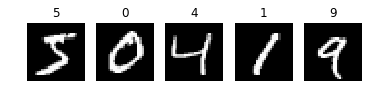

In [4]:
print("Original samples:")
for index, image in enumerate(train_images):
        plt.subplot(150 + 1 + index)
        plt.title(train_labels_raw[index])
        plt.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.axis('off')
plt.show()

### Den Generator zusammenbauen
Keras stellt für das Augmentieren von Bildern die Klasse `ImageDataGenerator` zur Verfügung. Sie verfügt über eine große Menge von unterschiedlichen Konfigurationsparametern, von denen ich hier nur die Wichtigsten zeige. Mit den Codeschnipseln und der [`ImageDataGenerator` Doku](https://keras.io/preprocessing/image/#imagedatagenerator-class) kannst Du die anderen aber einfach untersuchen. 

In [12]:
# define data preparation
datagen = ImageDataGenerator(
    # Wieviel Grad [0, 180] darf sich das Bild hin und her drehen
    rotation_range = 15, 
    # Um wieviel darf das Bild nach links und rechts bewegt werden
    width_shift_range=0.1, 
    # Um wieviel darf das Bild nach Oben und Unten bewegt werden
    height_shift_range=0.2, 
    # Die Varianz von dunkel zu hell 
    brightness_range = (0.1, 2), 
    # In welchem Bereich darf das Bild abgeschert werden
    shear_range = 0.3, 
    # In welchem Bereich dar das Bild die größe ändern
    zoom_range = 0.3, 
    # Bei Zahlen sollte man auf das Spiegeln eher verzichten :)
    horizontal_flip = False, 
    # Bei Zahlen sollte man auf das Spiegeln eher verzichten :)
    vertical_flip = False)

### Fitting der Daten
Manche Konfigurationen benötigen ein Preprocessing, bevor der Generator die Bilder fließen lassen kann. Speziell, wenn man die Daten ebne nicht von Hand normalisiert, wie ich das oben getan habe, oder wenn man über ein ZCA Whitening die Bilderfarbwerte untereinander normalisieren möchte. Ich brauche dieses Fitting hier eigentlich nicht, da man es aber nachher schnell mal vergisst und es nicht weh tut, wenn man es aufruft, tue ich es hier.

In [6]:
datagen.fit(train_images)

### Die Daten fließen lassen
Über die Methode `flow` kann man nun einen unendlichen Strom an Daten vom `ImageDataGenerator` anstoßen. Die Methode hat einige Parameter, über die man das Default – Verhalten des Generators verändern kann, ich denke aber, dass man eigentlich nur die `batch_size` von Hand setzen sollte. Dieser Parameter gibt an, wie viele Bilder in einem Schwung geliefert werden sollen. (_Diese Größe muss man später beim Trainieren des Modells kennen um die Blockgröße der Samples pro Epoche einstellen zu können._) 

Die wirklich wichtigen Daten sind natürlich die __Training Samples__ und die __Training Labels__, sonst gäbe es ja nichts, was man fließen lassen könnte.

In [13]:
sample_iterator = datagen.flow(train_images, train_labels_raw, batch_size=5)

### Einige Beispiele 
Mit jedem Aufruf des Iterators wird nun eine _batch_ von fünf Bildern geliefert, da ich das ja über den Paramater `batch_size` gerade so angefordert habe. Der Iterator arbeitet wirklich solange, bis man ihn mit Gewalt davon abhält. Somit steige ich hart aus der _for_ Schleife aus, wenn ich sechs Mal durch bin.

Iteration 0 of augmentation:


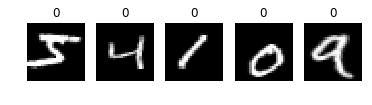

Iteration 1 of augmentation:


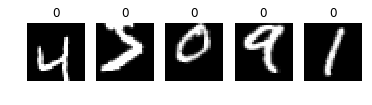

Iteration 2 of augmentation:


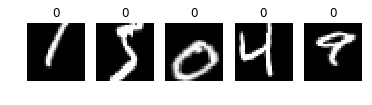

Iteration 3 of augmentation:


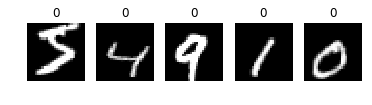

Iteration 4 of augmentation:


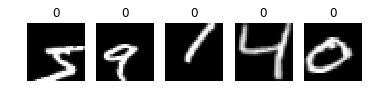

Iteration 5 of augmentation:


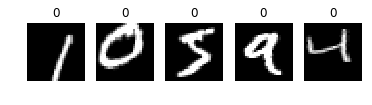

In [14]:
count = 0
for image_batch, label_batch in sample_iterator:
    print("Iteration {} of augmentation:".format(count))
    for i in range(0, 5):
        plt.subplot(150 + 1 + i)
        plt.title(label_batch[i].argmax())
        plt.imshow(image_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.show()
    count += 1
    if count == 6:
        break


Man erkennt deutlich, wie die Ziffern von Zeile zu Zeile ein wenig anders gezeichnet werden.

## Schluss
Mit diesem Blog habe ich das Featur des Augmentierens herausgezogen, um es dediziert und isoliert untersuchen zu können. In meinem nächsten Blog werde ich alles in einem einzigen großen Beispiel zusammenbauen um zu zeigen, dass man leicht über die 99,5% Genauigkeit kommen kann (Hangover 😉).

# SCHLAGWÖRTER
CNN, Augmentation, ImageDataGenerator, KI, AI, ML, Keras, TensorFlow, DNN, Deep Learning, Neuronale Netze, Tutorial, MNIST, Maschinelles Sehen, #KI-Werkbank

# BESCHREIBUNG
Ich zeige, wie man den Keras ImageDataGenerator in seine "KI Werkbank" einspannt um sie in das Augmentieren von Bildern einzuarbeiten.

# KATEGORIEN
Architektur, BI & DWH, Blog, Business Intelligence, KI